In [1]:
from pydub import AudioSegment
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
result = os.environ['PATH']
os.environ['PATH'] += os.pathsep + 'C:\\Program Files\\ffmpeg-2024-09-22-git-a577d313b2-full_build\\bin'

In [15]:
# final_audio = AudioSegment.from_file("final_audio_with_drinking_events.wav")
event_df = pd.read_csv("drinking_event_times.csv")

In [3]:
# event_df['start_onefourth_minute'] = event_df['start'] // 15000
# event_df['end_onefourth_minute'] = event_df['end'] // 15000

In [16]:
event_df['start_seconds'] = event_df['start'] // 1000
event_df['end_seconds'] = event_df['end'] // 1000

In [17]:
event_df['duration'] = event_df['end_seconds'] - event_df['start_seconds']

In [18]:
# add cumulative duration
event_df['cumulative_duration'] = event_df['duration'].cumsum()

In [19]:
event_df.head()

,start,end,sample_name,start_seconds,end_seconds,duration,cumulative_duration
0,1041,10016,library_water_bottle_0_elvis_162_aug2,1,10,9,9
1,196518,206521,home_water_bottle_0_elvis_111_aug1,196,206,10,19
2,408802,419868,library_water_bottle_0_elvis_152_aug1,408,419,11,30
3,439012,450013,library_water_bottle_0_elvis_206_aug1,439,450,11,41
4,535584,546568,home_water_bottle_0_elvis_179_aug2,535,546,11,52


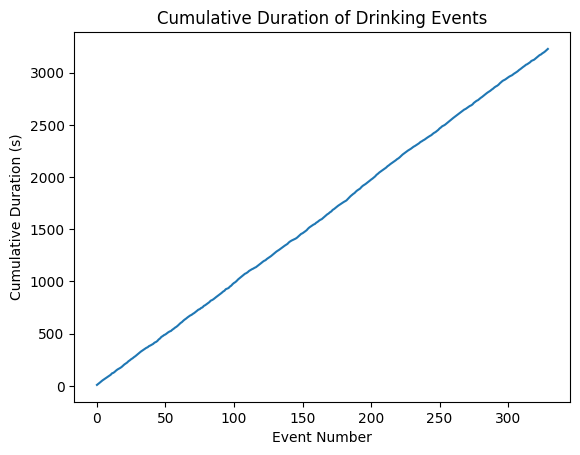

In [20]:
# plot cumulative duration
plt.plot(event_df['cumulative_duration'])
plt.xlabel('Event Number')
plt.ylabel('Cumulative Duration (s)')
plt.title('Cumulative Duration of Drinking Events')
plt.show()

In [21]:
# total duration of drinking events
total_duration = event_df['cumulative_duration'].iloc[-1]

In [22]:
# when is 75% of the total duration reached?
threefourths_duration = total_duration * 0.75

# find index of event after reaching 75% of total duration
end_seconds = event_df[event_df['cumulative_duration'] > threefourths_duration]['end_seconds'].iloc[0] + 1


In [23]:
end_seconds

27206

In [24]:
# separate into train and test on 75-25 split by splitting audio into 2 parts
train_audio = final_audio[:end_seconds * 1000]
test_audio = final_audio[end_seconds * 1000:]


In [25]:
# separate the dataframe
train_df = event_df[event_df['end_seconds'] < end_seconds].copy()
test_df = event_df[event_df['end_seconds'] >= end_seconds].copy()

In [30]:
test_df.head()

,start,end,sample_name,start_seconds,end_seconds,duration,cumulative_duration
247,52870,59910,home_water_bottle_0_elvis_197_aug1,52,59,7,7
248,120532,131578,home_water_bottle_0_elvis_135_aug1,120,131,11,18
249,208616,218619,home_water_bottle_0_elvis_111_aug0,208,218,10,28
250,238375,252357,ncs_water_bottle_0_elvis_102_aug0,238,252,14,42
251,379071,389120,ncs_water_bottle_0_elvis_106_aug0,379,389,10,52


In [27]:
# recalculate the start point of the test dataframe based on the new audio
test_df['start_seconds'] = test_df['start_seconds'] - end_seconds
test_df['end_seconds'] = test_df['end_seconds'] - end_seconds
test_df['start'] = test_df['start'] - end_seconds * 1000
test_df['end'] = test_df['end'] - end_seconds * 1000

In [29]:
# recalculating cumulative duration for test_df
test_df['cumulative_duration'] = test_df['duration'].cumsum()

In [31]:
training_drining_duration = train_df['cumulative_duration'].iloc[-1]
testing_drining_duration = test_df['cumulative_duration'].iloc[-1]

In [32]:
print(f"Training duration: {training_drining_duration} seconds")
print(f"Testing duration: {testing_drining_duration} seconds")

Training duration: 2424 seconds
Testing duration: 804 seconds


In [33]:
train_df['start_onefourth_minute'] = train_df['start'] // 15000
train_df['end_onefourth_minute'] = train_df['end'] // 15000

test_df['start_onefourth_minute'] = test_df['start'] // 15000
test_df['end_onefourth_minute'] = test_df['end'] // 15000

In [34]:
rows = []

for _, row in train_df.iterrows():
    for onefourth_minute in range(row['start_onefourth_minute'], row['end_onefourth_minute'] + 1):
        rows.append({"onefourth_minute": onefourth_minute, "water_drinking": 1})

# Create a DataFrame from rows and remove duplicates
train_drinking_df = pd.DataFrame(rows).drop_duplicates()

# Fill in missing quarter-minute intervals with water_drinking = 0
all_onefourth_minutes = range(train_drinking_df['onefourth_minute'].min(), train_drinking_df['onefourth_minute'].max() + 1)
all_onefourth_minutes_df = pd.DataFrame({"onefourth_minute": all_onefourth_minutes})
final_df = all_onefourth_minutes_df.merge(train_drinking_df, on="onefourth_minute", how="left")
final_df['water_drinking'] = final_df['water_drinking'].fillna(0).astype(int)
train_drinking_df = final_df.copy()

In [35]:
# do for test 
rows = []

for _, row in test_df.iterrows():
    for onefourth_minute in range(row['start_onefourth_minute'], row['end_onefourth_minute'] + 1):
        rows.append({"onefourth_minute": onefourth_minute, "water_drinking": 1})

# Create a DataFrame from rows and remove duplicates
test_drinking_df = pd.DataFrame(rows).drop_duplicates()

# Fill in missing quarter-minute intervals with water_drinking = 0
all_onefourth_minutes = range(test_drinking_df['onefourth_minute'].min(), test_drinking_df['onefourth_minute'].max() + 1)
all_onefourth_minutes_df = pd.DataFrame({"onefourth_minute": all_onefourth_minutes})
final_df = all_onefourth_minutes_df.merge(test_drinking_df, on="onefourth_minute", how="left")
final_df['water_drinking'] = final_df['water_drinking'].fillna(0).astype(int)
test_drinking_df = final_df.copy()

In [36]:
train_drinking_df.head()

,onefourth_minute,water_drinking
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


In [39]:
test_drinking_df.head()

,onefourth_minute,water_drinking
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0


In [38]:
# start the test_drinking_df with 0 1 2 onefourth_minute since they are missing currently, assign water_drinking = 0
test_drinking_df = pd.concat([pd.DataFrame({"onefourth_minute": [0, 1, 2], "water_drinking": [0, 0, 0]}), test_drinking_df], ignore_index=True)

In [40]:
train_df.head()

,start,end,sample_name,start_seconds,end_seconds,duration,cumulative_duration,start_onefourth_minute,end_onefourth_minute
0,1041,10016,library_water_bottle_0_elvis_162_aug2,1,10,9,9,0,0
1,196518,206521,home_water_bottle_0_elvis_111_aug1,196,206,10,19,13,13
2,408802,419868,library_water_bottle_0_elvis_152_aug1,408,419,11,30,27,27
3,439012,450013,library_water_bottle_0_elvis_206_aug1,439,450,11,41,29,30
4,535584,546568,home_water_bottle_0_elvis_179_aug2,535,546,11,52,35,36


In [41]:
test_df.head()

,start,end,sample_name,start_seconds,end_seconds,duration,cumulative_duration,start_onefourth_minute,end_onefourth_minute
247,52870,59910,home_water_bottle_0_elvis_197_aug1,52,59,7,7,3,3
248,120532,131578,home_water_bottle_0_elvis_135_aug1,120,131,11,18,8,8
249,208616,218619,home_water_bottle_0_elvis_111_aug0,208,218,10,28,13,14
250,238375,252357,ncs_water_bottle_0_elvis_102_aug0,238,252,14,42,15,16
251,379071,389120,ncs_water_bottle_0_elvis_106_aug0,379,389,10,52,25,25


In [42]:
def split_and_label_audio(audio, final_df, sr=16000, window_size=30, overlap=15):
    labeled_segments = []
    step = window_size - overlap  # Compute step size based on overlap
    
    for idx, row in final_df.iterrows():
        # Convert 'onefourth_minute' to milliseconds
        start_time = row['onefourth_minute'] * 15 * 1000  # Convert quarter minute to milliseconds
        end_time = start_time + window_size * 1000         # 30 seconds later
        
        # Check if the drinking event is in the current row or the next row
        if row['water_drinking'] == 1:
            label = 1
        elif idx + 1 < len(final_df) and final_df.iloc[idx + 1]['water_drinking'] == 1:
            label = 1
        else:
            label = 0
        
        # Extract the audio segment based on calculated start and end times
        segment = audio[start_time:end_time]
        
        # Append the segment and its label
        labeled_segments.append((segment, label))
        
        # Move to the next window with overlap
        start_time += step * 1000  # Move by step size in milliseconds
        end_time = start_time + window_size * 1000  # Update end time

    return labeled_segments

In [43]:
def extract_mfcc(audio_segment, sr=16000, n_mfcc=13):
    samples = np.array(audio_segment.get_array_of_samples()).astype(np.float32) / 32768.0
    mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to (time, n_mfcc)


In [45]:
train_audio_segments = split_and_label_audio(train_audio, train_drinking_df)
test_audio_segments = split_and_label_audio(test_audio, test_drinking_df)

# Extract MFCC features for each audio segment
train_mfccs = [extract_mfcc(segment) for segment, _ in train_audio_segments]
test_mfccs = [extract_mfcc(segment) for segment, _ in test_audio_segments]

train_labels = [label for _, label in train_audio_segments]
test_labels = [label for _, label in test_audio_segments]